# Assignment III
* Leoni Mota Loris

* At first, Load the data.

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [293]:
from collections import namedtuple

Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z', 'h', 'residue_seq_number'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())
Atom.parse_residue_seq_number = lambda string: int(string[23:30].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_x(string), Atom.parse_y(string), Atom.parse_z(string), 1,Atom.parse_residue_seq_number(string))

In [294]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return pd.DataFrame(atoms)

In [295]:
crambin = read_molecule('assets/1crn.pdb')
crambin[:10]

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,N,THR,17.047,14.099,3.625,1,1
1,CA,C,THR,16.967,12.784,4.338,1,1
2,C,C,THR,15.685,12.755,5.133,1,1
3,O,O,THR,15.268,13.825,5.594,1,1
4,CB,C,THR,18.170,12.703,5.337,1,1
5,OG1,O,THR,19.334,12.829,4.463,1,1
6,CG2,C,THR,18.150,11.546,6.304,1,1
7,N,N,THR,15.115,11.555,5.265,1,2
8,CA,C,THR,13.856,11.469,6.066,1,2
9,C,C,THR,14.164,10.785,7.379,1,2


## Question 1

## a)

* I) First we need to map the sequence of characters as in:

**TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATTCPGDYAN**
to a sequence of amino acids 

* II) And then, infer the position of each atom of the amino acid from a standard reference ($\alpha$ carbon) 


* III) Infer the position of multiple amino acids based on the peptide bond.

#### I) map the sequence of characters

In [296]:
aminoacid_mapping = {'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE',
                     'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE',
                     'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR'}
    
def map_to_aminoacids(sequence):
    return list(map(lambda char: aminoacid_mapping[char], sequence))

In [297]:
aminoacid_sequence = 'TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATTCPGDYAN'

In [298]:
aminoacids_names = map_to_aminoacids(aminoacid_sequence)

______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

In [299]:
def load_aminoacids():
    return list(map(lambda aminoacid_name: read_molecule('assets/' + aminoacid_name + '.pdb'), aminoacids_names))

In [300]:
aminoacids = load_aminoacids()

In [304]:
display(aminoacids[0])

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,,THR,0.080,-0.083,0.000,1,1
1,CA,,THR,1.539,-0.033,0.000,1,1
2,C,,THR,2.032,1.394,0.000,1,1
3,O,,THR,1.268,2.339,0.000,1,1
4,CB,,THR,2.116,-0.818,-1.226,1,1
5,OG1,,THR,1.743,-2.188,-1.162,1,1
6,CG2,,THR,3.654,-0.842,-1.361,1,1
7,1H,1,THR,-0.523,0.813,0.000,1,1
8,2H,2,THR,-0.461,-1.018,0.000,1,1
9,HA,,THR,1.904,-0.508,0.929,1,1


______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

#### III) Infer the position of multiple amino acids based on the peptide bond.


* After the nucleotilic attack the resonance delocalization of electrons in the peptide bond forces the creation of a plane where the atoms will be located (amide plan).

In [475]:
import numpy as np

def translation_matrix(delta_x, delta_y, delta_z, ref_x=.0, ref_y=.0, ref_z=.0):
    T = np.eye(4)
    T[0, -1], T[1, -1], T[2, -1] = delta_x - ref_x, delta_y - ref_y, delta_z - ref_z
    return T

def rotation_matrix(x_rotation_rad, y_rotation_rad, z_rotation_rad):
    Rx, Ry, Rz = np.eye(4), np.eye(4), np.eye(4)

    Rx[1, 1], Rx[1, 2], Rx[2, 1], Rx[2, 2] =\
        np.cos(x_rotation_rad), -np.sin(x_rotation_rad), np.sin(x_rotation_rad), np.cos(x_rotation_rad)
    
    Ry[0, 0], Ry[0, 2], Ry[2, 0], Ry[2, 2] =\
        np.cos(y_rotation_rad), np.sin(y_rotation_rad), -np.sin(y_rotation_rad), np.cos(y_rotation_rad)

    Rz[0, 0], Rz[0, 1], Rz[1, 0], Rz[1, 1] =\
        np.cos(z_rotation_rad), -np.sin(z_rotation_rad), np.sin(z_rotation_rad), np.cos(z_rotation_rad)

    return np.dot(np.dot(Rx, Ry), Rz)

def apply_transformation(transformation, df):
    df[['x', 'y', 'z', 'h']] = transformation.dot(df[['x', 'y', 'z', 'h']].T).T

def apply_rotation(transformation, df, atom_reference='N'):
    position = df[df.name == atom_reference].copy()
    print('tranlate\n', translation_matrix(-position.x, -position.y, -position.z))
    apply_transformation(translation_matrix(-position.x, -position.y, -position.z), df)
    print('result\n', df)
    print('rotate\n', transformation)
    apply_transformation(transformation, df)
    print('result\n', df)
    print('tranlate\n', translation_matrix(position.x, position.y, position.z))
    apply_transformation(translation_matrix(position.x, position.y, position.z), df)
    print('result\n', df)

* Some utility functions for calculating the euclidean distance and the angle between two vectors:


$$distance = \sqrt{|(A - B)|}$$


$$cos(\alpha) = \frac{A \cdot B}{|A||B|}$$ 

In [476]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def l2_norm(p):
    return np.sqrt(np.sum(p ** 2))

def get_angle_rad(a, b, normal_reference):
    negative = np.all(np.dot(np.cross(a, b), normal_reference) < 0)
    angle = np.arccos(((a).dot(b))/(l2_norm(a) * l2_norm(b))) 
    angle = angle if not np.isnan(angle) else .0
    return angle if not negative else -angle

In [477]:
def get_desired_omega(current_aminoacid):
    return 0.0 if 'PRO' in current_aminoacid.aminoacid.values else 180.0

def get_desired_OCN_angle(current_aminoacid):
    return 123.0 if 'PRO' in current_aminoacid.aminoacid.values else 123.5

def get_desired_CNCa_angle(current_aminoacid):
    return 126.0 if 'PRO' in current_aminoacid.aminoacid.values else 122.0

def get_desired_bond_length(current_aminoacid):
    return 1.32 if 'PRO' in current_aminoacid.aminoacid.values else 1.33

________________________________
* This function infers the position at which the amide nitrogen should be, so we can find a translation of the "next" aminoacid.


* It return a position that is equals to the rotation of the oxygen inside the plane C$\alpha$-C-N, and uses the length of the peptide bond (1.33Å or 1.32Å) and the Angle (123.5 or 123).

In [478]:
def get_desired_nitrogen_location(aminoacid):
    alpha_carbon = aminoacid[aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    carboxyl_carbon = aminoacid[aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    oxygen_double_bonded = aminoacid[aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)

    CO = oxygen_double_bonded - carboxyl_carbon
    CA = alpha_carbon - carboxyl_carbon

    plane_normal = np.cross(CO, CA)
    plane_vector_basis = np.array([
        np.cross(CO, plane_normal) / l2_norm(np.cross(CO, plane_normal)), 
        CO / l2_norm(CO), 
        plane_normal / l2_norm(plane_normal)]).T

    CO_new_norm = CO * get_desired_bond_length(aminoacid) / l2_norm(CO)
    CO_new_norm_plane = np.linalg.solve(plane_vector_basis, CO_new_norm)[:2]
    
    rotation_angle = np.radians(get_desired_OCN_angle(aminoacid))
    rotation_angle_matrix = np.array(
        [[np.cos(rotation_angle), -np.sin(rotation_angle)], 
         [np.sin(rotation_angle), np.cos(rotation_angle)]])

    CN_plane = CO_new_norm_plane @ rotation_angle_matrix
    CN = np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array([CN_plane[0], CN_plane[1], 0]))
    N_desired = CN + carboxyl_carbon
    
    return np.pad(N_desired, (0, 1), 'constant', constant_values=1)

In [479]:
def get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C'):
    if terminal == 'C':
        alpha_carbon = previous_aminoacid[previous_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        oxygen_double_bonded = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
        C1 = oxygen_double_bonded - carboxyl_carbon
        C2 = alpha_carbon - carboxyl_carbon
    if terminal == 'N':
        last_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        C2 = last_carbon - nitrogen_amide
        C1 = carboxyl_carbon - nitrogen_amide
    return np.cross(C1, C2), C1, C2

* The actual translations and rotations happens below:
    * We first translate the "next" aminoacid and then we do the rotations so the angles and distances can be as depicted below:
   
![assets/rotation.png](assets/pep.png)

* This method translates the `current_aminoacid` so its Nitrogen will be at the right spot for the peptide bond.

In [480]:
def translate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    desired_nitrogen_location = get_desired_nitrogen_location(previous_aminoacid)
    current_nitrogen_location = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z', 'h']].values.reshape(-1,)
        
    required_tranlation = desired_nitrogen_location - current_nitrogen_location
    
    required_tranlation_matrix = translation_matrix(required_tranlation[0], required_tranlation[1], required_tranlation[2])
    apply_transformation(required_tranlation_matrix, current_aminoacid)
    

* This method rotates the `current_aminoacid` so the normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ and the normal of the plane $C-N_{i+1}-C\alpha_{i+1}$ can be aligned.

In [501]:
def rotate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    omega_rad = np.radians(get_desired_omega(current_aminoacid))
    previous_normal, co, ca = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C')
    current_normal, nca, nc = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='N')

    rotation_angle_x = get_angle_rad(current_normal[[1, 2]], previous_normal[[1, 2]], 
                                     -previous_normal[[1, 2]])
    print('rotation_angle_x', rotation_angle_x)
#     print('BEFORE LA CAQUINHA', current_aminoacid)
    if rotation_angle_x != 0:
        print(current_normal[[1, 2]], previous_normal[[1, 2]])
        apply_rotation(rotation_matrix(-rotation_angle_x, 0, 0), current_aminoacid)
        
        previous_normal, co, ca = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C')
        current_normal, nca, nc = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='N')
        print(current_normal[[1, 2]], previous_normal[[1, 2]])
        
#     print('AFTER LA CAQUINHA', current_aminoacid)
    
#     previous_normal, co, ca = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C')
#     print('np.dot(previous_normal, co)', np.dot(previous_normal, co))
#     print('np.dot(previous_normal, ca)', np.dot(previous_normal, ca))
        
#     current_normal, nca, nc = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='N')
#     print('np.dot(current_normal, nca)', np.dot(current_normal, nca))
#     print('np.dot(current_normal, nc)', np.dot(current_normal, nc))
#     print(previous_normal, current_normal, previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0])
#     rotation_angle_x = get_angle_rad(current_normal[[1, 2]], previous_normal[[1, 2]], 
#                                      -previous_normal[[1, 2]])
#     print('NEED ROTATTIONES IN X????????????????????????/', rotation_angle_x)
    
#     current_normal = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='N')
#     rotation_angle_y = get_angle_rad(current_normal[[0, 2]], previous_normal[[0, 2]], 
#                                      -previous_normal[[0, 2]])
#     print('rotation_angle_y', rotation_angle_y)
#     apply_rotation(rotation_matrix(0, rotation_angle_y, 0), current_aminoacid)
    
#     current_normal = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='N')
#     rotation_angle_z = get_angle_rad(current_normal[[0, 1]], previous_normal[[0, 1]],
#                                      -previous_normal[[0, 1]])
#     print('rotation_angle_z', rotation_angle_z)
#     apply_rotation(rotation_matrix(0, 0, rotation_angle_z), current_aminoacid)

* This method rotates the `current_aminoacid` in the direction of a normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ stainding at the $N_i$ so the angle $C_i-N_{i+1}-C\alpha_{i+1}$ can be either 122 or 126 (*trans* / *cis*).

In [502]:
def rotate_for_CNCa_angle(previous_aminoacid, current_aminoacid):
    carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    alpha_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)

    NC = carboxyl_carbon - nitrogen_amide
    NCa = alpha_carbon - nitrogen_amide

    plane_normal = np.cross(NCa, NC)
    plane_vector_basis = np.array([
        np.cross(NC, plane_normal) / l2_norm(np.cross(NC, plane_normal)), 
        NC / l2_norm(NC),
        plane_normal / l2_norm(plane_normal)]).T

    current_CNCa_angle_rad = get_angle_rad(NC, NCa, -plane_normal)
    desired_CNCa_angle_rad = np.radians(get_desired_CNCa_angle(current_aminoacid))
    
    needed_rotation_rad = desired_CNCa_angle_rad - current_CNCa_angle_rad
    
    new_current_aminoacid = current_aminoacid.copy()
    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(plane_vector_basis, np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    apply_rotation(rotation_matrix(0, 0, needed_rotation_rad), new_current_aminoacid)

    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    new_alpha_carbon = new_current_aminoacid[new_current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    NC = carboxyl_carbon - nitrogen_amide
    NCa = new_alpha_carbon - nitrogen_amide

In [503]:
def dehydration(aminoacid1, aminoacid2):
    aminoacid1 = aminoacid1[~aminoacid1.name.isin(['OC', 'HC'])]    

__________________________
* Functions to verify the constrains regarding angles and distances in the amide plane.

In [504]:
def check_peptide_bond_length(previous_aminoacid, current_aminoacid):
    a = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    b = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    print('euclidean_distance for the peptide bond between %s and %s: %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], euclidean_distance(a, b)))
    
def check_OCN_angle(previous_aminoacid, current_aminoacid):
    c = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    n = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    o = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
    print('O-C-N Angle for the peptide bond between %s and %s:        %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], abs(180*get_angle_rad(o-c, n-c, (o-c))/np.pi)))

In [505]:
aminoacids_df = load_aminoacids()
for i in range(1, len(aminoacids_df)):
    current_aminoacid = aminoacids_df[i]
    previous_aminoacid = aminoacids_df[i - 1]
    
    dehydration(previous_aminoacid, current_aminoacid)
    translate_for_peptide_bond(previous_aminoacid, current_aminoacid)
    rotate_for_peptide_bond(previous_aminoacid, current_aminoacid)

print('last aminoacid:')
display(current_aminoacid)

rotation_angle_x 0.0
rotation_angle_x 0.0
rotation_angle_x 0.0
rotation_angle_x 0.41962476664541776
[-0.21469676  0.48125064] [0.      1.58642]
tranlate
 [[  1.           0.           0.         -13.03427231]
 [  0.           1.           0.          -6.61659264]
 [  0.           0.           1.          -0.        ]
 [  0.           0.           0.           1.        ]]
result
    name element aminoacid      x      y      z    h  residue_seq_number
0     N               PRO  0.000  0.000  0.000  1.0                   1
1    CA               PRO  1.510 -0.154 -0.163  1.0                   1
2     C               PRO  2.143  0.844 -1.129  1.0                   1
3     O               PRO  1.390  1.680 -1.689  1.0                   1
4    CB               PRO  1.738 -1.553 -0.717  1.0                   1
5    CG               PRO  0.486 -1.723 -1.594  1.0                   1
6    CD               PRO -0.635 -1.113 -0.746  1.0                   1
7     H               PRO -0.487  0.739  

rotation_angle_x -0.5858579913402167
[ 0.33493578 -0.08250595] [1.49500033 0.53613637]
tranlate
 [[  1.           0.           0.         -22.88970045]
 [  0.           1.           0.          -7.99376431]
 [  0.           0.           1.           1.85872614]
 [  0.           0.           0.           1.        ]]
result
     name element aminoacid      x      y      z    h  residue_seq_number
0      N       N       VAL  0.000  0.000  0.000  1.0                   1
1     CA       C       VAL  1.452  0.155  0.000  1.0                   1
2      C       C       VAL  1.840  1.615  0.000  1.0                   1
3      O       O       VAL  0.995  2.518  0.000  1.0                   1
4     CB       C       VAL  2.071 -0.591 -1.248  1.0                   1
5    CG1       C       VAL  1.882 -2.127 -1.217  1.0                   1
6    CG2       C       VAL  3.588 -0.370 -1.501  1.0                   1
7     1H       H       VAL -0.666  0.850  0.000  1.0                   1
8     2H       H 

[ 0.15685227 -0.29555741] [ 0.85111797 -1.32441859]
rotation_angle_x -0.1609618900625309
[0.01229079 0.05128911] [0.11697552 1.57274086]
tranlate
 [[  1.           0.           0.         -35.85589337]
 [  0.           1.           0.         -11.04249822]
 [  0.           0.           1.           1.98644515]
 [  0.           0.           0.           1.        ]]
result
     name element aminoacid      x      y      z    h  residue_seq_number
0      N               ASN  0.000  0.000  0.000  1.0                   1
1     CA               ASN  1.457  0.086  0.000  1.0                   1
2      C               ASN  1.914  1.526  0.000  1.0                   1
3      O               ASN  1.117  2.463  0.000  1.0                   1
4     CB               ASN  2.023 -0.671 -1.237  1.0                   1
5     CG               ASN  1.639 -2.148 -1.381  1.0                   1
6    OD1               ASN  0.756 -2.521 -2.139  1.0                   1
7    ND2               ASN  2.263 -3.034

     name element aminoacid      x         y         z    h  residue_seq_number
0      N       N       VAL  0.000  0.000000  0.000000  1.0                   1
1     CA       C       VAL  1.452  0.076202 -0.134975  1.0                   1
2      C       C       VAL  1.840  0.793974 -1.406354  1.0                   1
3      O       O       VAL  0.995  1.237911 -2.192692  1.0                   1
4     CB       C       VAL  2.071 -1.377318 -0.098901  1.0                   1
5    CG1       C       VAL  1.882 -2.105458  1.253900  1.0                   1
6    CG2       C       VAL  3.588 -1.488983 -0.415730  1.0                   1
7     1H       H       VAL -0.666  0.417881 -0.740186  1.0                   1
8     2H       H       VAL -0.472 -0.477368  0.845554  1.0                   1
9     HA       H       VAL  1.857  0.667013  0.706149  1.0                   1
10    HB       H       VAL  1.543 -1.977443 -0.870640  1.0                   1
11  1HG1       H       VAL  2.434 -1.613106  2.0761

tranlate
 [[  1.           0.           0.         -57.77039403]
 [  0.           1.           0.         -19.45639011]
 [  0.           0.           1.           4.12992976]
 [  0.           0.           0.           1.        ]]
result
    name element aminoacid      x      y      z    h  residue_seq_number
0     N               PRO  0.000  0.000  0.000  1.0                   1
1    CA               PRO  1.510 -0.154 -0.163  1.0                   1
2     C               PRO  2.143  0.844 -1.129  1.0                   1
3     O               PRO  1.390  1.680 -1.689  1.0                   1
4    CB               PRO  1.738 -1.553 -0.717  1.0                   1
5    CG               PRO  0.486 -1.723 -1.594  1.0                   1
6    CD               PRO -0.635 -1.113 -0.746  1.0                   1
7     H               PRO -0.487  0.739  0.528  1.0                   1
8    HA               PRO  2.000 -0.018  0.790  1.0                   1
9   1HB       1       PRO  2.624 -1.545 -

[-0.15233905  0.45955551] [-0.25941179  1.53433803]
rotation_angle_x -1.5192324025477248
[ 0.25431252 -0.43893874] [1.49199257 0.76456823]
tranlate
 [[  1.           0.           0.         -71.06844357]
 [  0.           1.           0.         -20.91972945]
 [  0.           0.           1.           7.30811009]
 [  0.           0.           0.           1.        ]]
result
    name element aminoacid      x      y      z    h  residue_seq_number
0     N               GLU  0.000  0.000  0.000  1.0                   1
1    CA               GLU  1.447  0.196  0.000  1.0                   1
2     C               GLU  1.793  1.666  0.000  1.0                   1
3     O               GLU  0.931  2.536  0.000  1.0                   1
4    CB               GLU  2.042 -0.523 -1.242  1.0                   1
5    CG               GLU  1.651  0.035 -2.651  1.0                   1
6    CD               GLU  2.141 -0.715 -3.892  1.0                   1
7   OE1               GLU  1.859 -0.371 -5.032

    name element aminoacid      x      y      z    h  residue_seq_number
0     N               CYS  0.000  0.000  0.000  1.0                   1
1    CA               CYS  1.456  0.114  0.000  1.0                   1
2     C               CYS  1.884  1.562  0.000  1.0                   1
3     O               CYS  1.063  2.491  0.000  1.0                   1
4    CB               CYS  2.009 -0.664 -1.210  1.0                   1
5    SG               CYS  3.814 -0.713 -1.168  1.0                   1
6    1H       1       CYS -0.642  0.868  0.000  1.0                   1
7    2H       2       CYS -0.499 -0.958  0.000  1.0                   1
8    HA               CYS  1.840 -0.342  0.931  1.0                   1
9    HO               CYS  1.563  3.392  0.000  1.0                   1
10  1HB       1       CYS  1.641 -1.706 -1.218  1.0                   1
11  2HB       2       CYS  1.676 -0.214 -2.168  1.0                   1
12   HG               CYS  4.021  0.179 -2.134  1.0            

rotation_angle_x -0.1548688059221108
[0.06086088 0.11917856] [0.49233512 1.49932458]
tranlate
 [[  1.           0.           0.         -93.71801058]
 [  0.           1.           0.         -26.74796814]
 [  0.           0.           1.           4.68339423]
 [  0.           0.           0.           1.        ]]
result
     name element aminoacid      x      y      z    h  residue_seq_number
0      N               THR  0.000  0.000  0.000  1.0                   1
1     CA               THR  1.459  0.050  0.000  1.0                   1
2      C               THR  1.952  1.477  0.000  1.0                   1
3      O               THR  1.188  2.422  0.000  1.0                   1
4     CB               THR  2.036 -0.735 -1.226  1.0                   1
5    OG1               THR  1.663 -2.105 -1.162  1.0                   1
6    CG2               THR  3.574 -0.759 -1.361  1.0                   1
7     1H       1       THR -0.603  0.896  0.000  1.0                   1
8     2H       2   

21                   1  
[0.24902872 0.12373159] [0.33191691 1.55130899]
rotation_angle_x 0.7198532077375362
[-0.28925384 -0.02934234] [-1.29377011  0.92120957]
tranlate
 [[   1.            0.            0.         -106.44630514]
 [   0.            1.            0.          -29.7224889 ]
 [   0.            0.            1.            4.48408369]
 [   0.            0.            0.            1.        ]]
result
     name element aminoacid      x      y      z    h  residue_seq_number
0      N               ILE  0.000  0.000  0.000  1.0                   1
1     CA               ILE  1.449  0.180  0.000  1.0                   1
2      C               ILE  1.812  1.646  0.000  1.0                   1
3      O               ILE  0.949  2.536  0.000  1.0                   1
4     CB               ILE  2.126 -0.594 -1.203  1.0                   1
5    CG1               ILE  1.734 -2.103 -1.310  1.0                   1
6    CG2               ILE  3.683 -0.499 -1.185  1.0                   1


result
   name element aminoacid      x      y      z    h  residue_seq_number
0    N               GLY  0.000  0.000  0.000  1.0                   1
1   CA               GLY  1.450  0.171  0.000  1.0                   1
2    C               GLY  1.823  1.634  0.000  1.0                   1
3    O               GLY  0.975  2.521  0.000  1.0                   1
4   1H       1       GLY -0.461 -0.977  0.000  1.0                   1
5   2H       2       GLY -0.675  0.843  0.000  1.0                   1
6  1HA       1       GLY  1.893 -0.317  0.888  1.0                   1
7  2HA       2       GLY  1.893 -0.317 -0.888  1.0                   1
8   OC               GLY  3.223  1.924  0.000  1.0                   1
9  HOC               GLY  3.757  1.043  0.000  1.0                   1
rotate
 [[ 1.          0.          0.          0.        ]
 [ 0.         -0.04848214 -0.99882405  0.        ]
 [ 0.          0.99882405 -0.04848214  0.        ]
 [ 0.          0.          0.          1.        ]

rotation_angle_x -0.82128225145577
[0.05123227 0.02586041] [0.43311947 1.49462209]
tranlate
 [[   1.            0.            0.         -129.15793415]
 [   0.            1.            0.          -37.52819377]
 [   0.            0.            1.            3.62393281]
 [   0.            0.            0.            1.        ]]
result
    name element aminoacid      x      y      z    h  residue_seq_number
0     N               CYS  0.000  0.000  0.000  1.0                   1
1    CA               CYS  1.456  0.114  0.000  1.0                   1
2     C               CYS  1.884  1.562  0.000  1.0                   1
3     O               CYS  1.063  2.491  0.000  1.0                   1
4    CB               CYS  2.009 -0.664 -1.210  1.0                   1
5    SG               CYS  3.814 -0.713 -1.168  1.0                   1
6    1H       1       CYS -0.642  0.868  0.000  1.0                   1
7    2H       2       CYS -0.499 -0.958  0.000  1.0                   1
8    HA       

    name element aminoacid           x          y         z    h  \
0     N       N       ASP  138.936093  39.389984 -1.822613  1.0   
1    CA       C       ASP  140.381093  39.652329 -1.591149  1.0   
2     C       C       ASP  140.793093  40.661557 -0.460990  1.0   
3     O       O       ASP  140.019093  41.220883  0.281467  1.0   
4    CB       C       ASP  140.926093  40.055331 -2.974580  1.0   
5    CG       C       ASP  142.468093  39.990951 -3.149166  1.0   
6   OD1       O       ASP  143.092093  39.363664 -2.289343  1.0   
7   OD2       O       ASP  142.889093  40.575089 -4.148743  1.0   
8    1H       H       ASP  138.369093  39.873948 -1.141250  1.0   
9    2H       H       ASP  138.728093  39.573127 -2.793905  1.0   
10   HA       H       ASP  140.834093  38.681245 -1.309331  1.0   
11  1HB       H       ASP  140.532093  39.362512 -3.740864  1.0   
12  2HB       H       ASP  140.575093  41.055538 -3.276446  1.0   
13   OC       O       ASP  142.123093  40.873709 -0.317905  1

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,,ASN,148.722496,43.727515,-1.235846,1.0,1
1,CA,,ASN,150.179496,43.679818,-1.164285,1.0,1
2,C,,ASN,150.636496,42.881171,0.033948,1.0,1
3,O,,ASN,149.839496,42.361495,0.813632,1.0,1
4,CB,,ASN,150.745496,45.128978,-1.108129,1.0,1
5,CG,,ASN,150.361496,46.067969,-2.257285,1.0,1
6,OD1,,ASN,149.478496,46.905578,-2.147262,1.0,1
7,ND2,,ASN,150.985496,45.952754,-3.398847,1.0,1
8,1H,1,ASN,148.096496,43.239453,-0.503592,1.0,1
9,2H,2,ASN,148.205496,44.253291,-2.024683,1.0,1


* We have all the atoms aligned accordingly. So, let's create string rows for the pdb.

In [450]:
def write_atom_to_file(atom_row, aminoacid_seq_number, fd):
    global atom_seq_number
    atom_seq_number += 1
    if 'H' not in atom_row[0]:
        atom_row.element = ''.join(filter(str.isalpha, atom_row[0]))[0]
        template_row =\
        'ATOM    '+\
        ('%d'%atom_seq_number).rjust(3)+\
        '  '+\
        ('%s'%atom_row[0]).rjust(3)+\
        ' '+\
        ('%s'%atom_row.aminoacid).rjust(3)+\
        ' A'+\
        ('%d'%aminoacid_seq_number).rjust(4)+\
        '    '+\
        ('%.3f'%atom_row.x).rjust(8)+\
        ('%.3f'%atom_row.y).rjust(8)+\
        ('%.3f'%atom_row.x).rjust(8)+\
        '  1.00  5.99           '+\
        ('%s\n'%atom_row.element)
        f.write(template_row)

In [451]:
atom_seq_number = 0

with open('assets/final_inferred_molecule.pdb', 'w') as f:
    for idx, aminoacid in enumerate(aminoacids_df):
        for atom_row in aminoacid.iterrows():
            write_atom_to_file(atom_row[1], idx, f)

with open("assets/final_inferred_molecule.pdb") as f:
    head = [next(f) for x in range(5)]
print('\n'.join(head))
print('...')

ATOM      1    N THR A   0       0.080  -0.083   0.080  1.00  5.99           N

ATOM      2   CA THR A   0       1.539  -0.033   1.539  1.00  5.99           C

ATOM      3    C THR A   0       2.032   1.394   2.032  1.00  5.99           C

ATOM      4    O THR A   0       1.268   2.339   1.268  1.00  5.99           O

ATOM      5   CB THR A   0       2.116  -0.818   2.116  1.00  5.99           C

...


_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________


## b) Receive PDB file and list $\phi$ and $\psi$

$$ ψ  = Angle( Normal(N_{i}, C_{\alpha i}, C_{i}); Normal(C_{\alpha i}, C_{i}, N_{i+1}) ) $$

$$φ = Angle( Normal(C_{i-1}, N_{i}, C_{\alpha i}); Normal(N_{i}, C_{\alpha i}, C_{i}) )$$

![assets/phi_psi.png](assets/phi_psi.png)

In [58]:
def compute_psi(ni, cai, ci, ni1):
    normal_cai = np.cross((ni - cai), (ci - cai))
    normal_ci = np.cross((cai - ci), (ni1 - ci))
    return np.degrees(get_angle_rad(normal_cai, normal_ci, (ci-cai)))

def compute_phi(ci_prev, ni, cai, ci):
    normal_ni = np.cross((ci_prev - ni), (cai - ni))
    normal_cai = np.cross((ni - cai), (ci - cai))
    return np.degrees(get_angle_rad(normal_ni, normal_cai, -(ni-cai)))

In [59]:
def get_phy_psi(molecule):
    molecule['phi'] = None
    molecule['psi'] = None

    data = []

    for i in range(1, len(molecule.residue_seq_number.unique())):
        aminoacid_i = molecule[molecule.residue_seq_number == (i)]
        ni = aminoacid_i[aminoacid_i.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        cai = aminoacid_i[aminoacid_i.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        ci = aminoacid_i[aminoacid_i.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        angle_data = {'residue_name': aminoacid_i.aminoacid.values[0], 'phi': None, 'psi': None}
        try:
            aminoacid_prev = molecule[molecule.residue_seq_number == (i-1)]
            ci_prev = aminoacid_prev[aminoacid_prev.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
            angle_data['phi'] = compute_phi(ci_prev, ni, cai, ci)
        except: pass

        try:
            aminoacid_i1 = molecule[molecule.residue_seq_number == (i+1)]
            ni1 = aminoacid_i1[aminoacid_i1.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
            angle_data['psi'] = compute_psi(ni, cai, ci, ni1)
        except: pass

        data.append(angle_data)
    return data

In [61]:
molecule = read_molecule('assets/1crn.pdb')
phi_psi = pd.DataFrame(get_phy_psi(molecule))
phi_psi[:10]

,phi,psi,residue_name
0,NaN,147.660026,THR
1,-107.832573,144.346241,THR
2,-131.170389,133.291143,CYS
3,-118.896523,151.202717,CYS
4,-76.181506,-18.979386,PRO
5,-157.924288,166.027161,SER
6,-63.579524,-42.100632,ILE
7,-55.930329,-44.561332,VAL
8,-61.364845,-43.779138,ALA
9,-63.193412,-43.303486,ARG


## c) Ramachandran 

In [62]:
molecule = read_molecule('assets/1crn.pdb')
phi_psi = pd.DataFrame(get_phy_psi(molecule))
phi_psi[:10]

,phi,psi,residue_name
0,NaN,147.660026,THR
1,-107.832573,144.346241,THR
2,-131.170389,133.291143,CYS
3,-118.896523,151.202717,CYS
4,-76.181506,-18.979386,PRO
5,-157.924288,166.027161,SER
6,-63.579524,-42.100632,ILE
7,-55.930329,-44.561332,VAL
8,-61.364845,-43.779138,ALA
9,-63.193412,-43.303486,ARG


In [63]:
phi_psi = phi_psi.fillna(0)

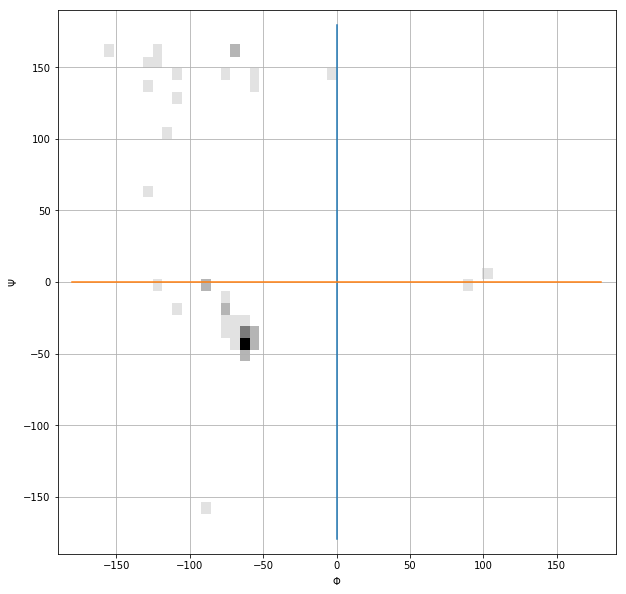

In [65]:
plt.figure(figsize=(10, 10))

plt.hist2d(phi_psi.phi, phi_psi.psi, bins=(40, 40), cmap=plt.cm.Greys);
plt.plot(np.zeros_like(phi_psi.phi), np.linspace(-180, 180, len(phi_psi.phi)))
plt.plot(np.linspace(-180, 180, len(phi_psi.phi)), np.zeros_like(phi_psi.phi))
plt.xlabel('$\Phi$')
plt.ylabel('$\Psi$')
plt.xlim([-190, 190])
plt.ylim([-190, 190])
plt.grid()
plt.show()

__________________
__________________
__________________
__________________
__________________



## d) Secondary structure:

*When five or more consecutive amino acids have torsion angles in the $\alpha$-helical region of the Ramachandran plot, the
hydrogen bonds typical of the $\alpha$-helix will form and the structure will snap into a very highly populated and finely
focused area near '$\phi$ = 63.8°, $\psi$ = 41.1° (..) as 39% of all 237 384 amino acids were found here, in an area
just 2% of the Ramachandran plot -89° < $\phi$ < -39°, -66° < $\psi$ < -16°*
___________________________
(...)


*The conformations of the amino acids in five of the six groups were surprisingly similar with respect to both the average and values (all within -130° < $\phi$ < -105° and 128° < $\psi$ < 147°) for the first five groups and the standard deviations (15...26°).*
___________________________

    - Source: HOVMOLLER S1, ZHOU T, OHLSON T. Conformations of amino acids in proteins. Acta Crystallogr D Biol Crystallogr

In [66]:
alpha_helix_phi = (-89, -39)
alpha_helix_psi = (-66, -16)
beta_sheet_phi = (-130, -105)
beta_sheet_psi = (128, 147)
N_AMINOACIDS = 5

In [67]:
secondary_structure = []
for i, row in phi_psi.iterrows():
    if alpha_helix_phi[0] < row.loc['phi'] < alpha_helix_phi[1] and\
       alpha_helix_psi[0] < row.loc['psi'] < alpha_helix_psi[1]:
        secondary_structure.append('H')
    elif beta_sheet_phi[0] < row.loc['phi'] < beta_sheet_phi[1] and\
         beta_sheet_psi[0] < row.loc['psi'] < beta_sheet_psi[1]:
        secondary_structure.append('B')
    else:
        secondary_structure.append('-')

In [68]:
print('Primary Structure:')
print('TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN\n')
print('Secondary Structure:')
print(''.join(secondary_structure))


Primary Structure:
TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN

Secondary Structure:
-B--H-HHHHHHHHHHHH----HHHHHHH----B-H-----H---
